## Sentiment Analysis on Trustpilot Data (Mexico Movistar)

In [ ]:
!pip install nltk matplotlib seaborn wordcloud langdetect googletrans==4.0.0-rc1 vaderSentiment

In [1]:
import pandas as pd
import re

In [2]:
# Load the Trustpilot Mexico dataset
df = pd.read_csv("./reviews/MX/trustpilot_movistar_reviews.csv")

In [3]:
df.head(2)

,username,review
0,PJ,"Slow, specially in Sumer, to the point of bein..."
1,PJ Jones,Shocking service. Out of contract and monthly ...


In [4]:
# Clean up any missing reviews
df = df.dropna(subset=["review"])

In [5]:
# lowercase, remove non-alphabetic characters
df["clean_review"] = df["review"].str.lower().apply(lambda x: re.sub(r"[^a-z\s]", "", x))

In [6]:
providers = ["movistar", "true", "zeleris"]
pattern = r'\b(?:' + '|'.join(providers) + r')\b'
df["clean_review"] = df["clean_review"].str.replace(pattern, "", regex=True)

In [7]:
df["clean_review"] = df["clean_review"].str.replace(r'€|\$|euro|usd', '', regex=True)

In [8]:
df["clean_review"] = df["clean_review"].str.replace(r'\b\d{10,}\b', '', regex=True)  # phone numbers
df["clean_review"] = df["clean_review"].str.replace(r'\S+@\S+', '', regex=True)  # emails

In [15]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\deyna\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [16]:
stop_words = set(stopwords.words('english'))

df["clean_review"] = df["clean_review"].apply(lambda x: ' '.join([w for w in x.split() if w not in stop_words]))

In [17]:
from langdetect import detect
from googletrans import Translator

In [18]:
translator = Translator()

def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

df["language"] = df["clean_review"].apply(detect_language)

In [19]:
# Translate only non-English
def translate_if_needed(row):
    if row["language"] != "en":
        try:
            return translator.translate(row["clean_review"], dest='en').text
        except:
            return row["clean_review"]
    else:
        return row["clean_review"]

df["translated_review"] = df.apply(translate_if_needed, axis=1)

In [20]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [21]:
nltk.download("vader_lexicon")

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\deyna\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [22]:
# Run sentiment analysis
df["sentiment"] = df["translated_review"].apply(lambda x: sid.polarity_scores(x)["compound"])

# Label sentiment for easier interpretation
def label_sentiment(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

df["sentiment_label"] = df["sentiment"].apply(label_sentiment)

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

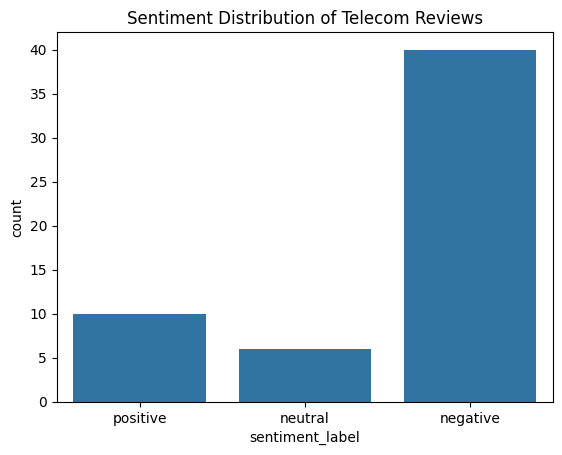

In [24]:
sns.countplot(data=df, x="sentiment_label", order=["positive", "neutral", "negative"])
plt.title("Sentiment Distribution of Telecom Reviews")
plt.show()

In [25]:
from wordcloud import WordCloud

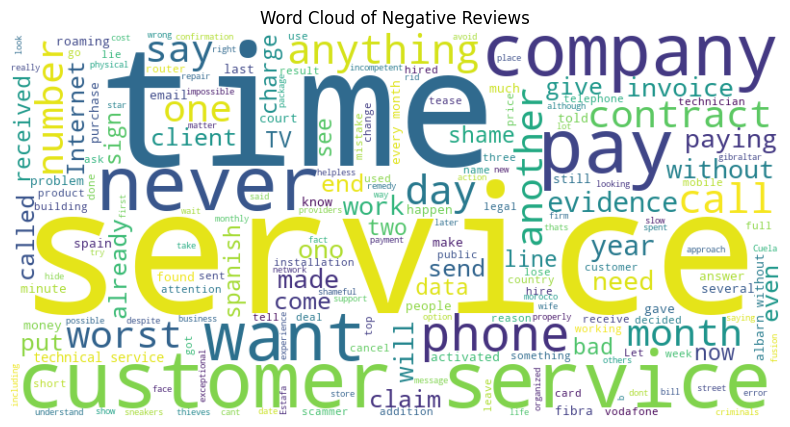

In [26]:
text = " ".join(df[df["sentiment_label"] == "negative"]["translated_review"])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Negative Reviews")
plt.show()

In [27]:
# Summary stats
summary = df.groupby("sentiment_label").agg(
    count=("sentiment", "count"),
    avg_score=("sentiment", "mean")
).reset_index()

print(summary)

  sentiment_label  count  avg_score
0        negative     40  -0.617633
1         neutral      6  -0.004300
2        positive     10   0.419700
